Not measuring or reporting on bandwidth as it was all about the same regardless of the profile (SSE,SSL).

In [46]:
# PREAMBLE
%matplotlib inline
create_external_graphs = False

import re
import io
import os.path
from functools import reduce

import pandas as pd

import numpy as np

from ggplot import *

## CPU

Measuring relative performance and resource utilization using the [AWS CLI](https://aws.amazon.com/cli/). See [Test Environment Setup](Test%20Environment%20Setup.ipynb#AWS-CLI) for more details.

Color legend for graphs:

<span style="color:red; font-size:24px">■</span> **no_ssl_cpu** - Transfer to S3 with TLS/SSL *disabled* and Server Side Encryption *disabled*<br>
<span style="color:blue; font-size:24px">■</span> **yes_ssl_cpu** - Transfer to S3 with TLS/SSL *enabled* and Server Side Encryption *disabled*<br>
<span style="color:green; font-size:24px">■</span> **yes_sse_cpu** - Transfer to S3 with TLS/SSL *enabled* and Server Side Encryption *enabled*

### 8 Concurrent Uploads

In [47]:
# PROCESS SAR CPU METRICS
FIND_CPU = re.compile(".+ all .+")
CPU_COLS = ["cpu"]
SAMPLES = 5
SAMPLE_RANGE = range(1, SAMPLES+1)

cpu_df = lambda fname: pd.read_fwf(io.StringIO("".join(filter(FIND_CPU.match, open(fname)))), header=None)\
                             .loc[:,[8]]

async_no_ssl_cpus = tuple(cpu_df(os.path.join("reports2", "async_no_ssl_no_sse-cpu.{}.sar.txt".format(i)))
                          for i in SAMPLE_RANGE)
async_yes_ssl_cpus = tuple(cpu_df(os.path.join("reports2", "async_yes_ssl_no_sse-cpu.{}.sar.txt".format(i)))
                           for i in SAMPLE_RANGE)
async_yes_sse_cpus = tuple(cpu_df(os.path.join("reports2", "async_yes_ssl_yes_sse-cpu.{}.sar.txt".format(i)))
                           for i in SAMPLE_RANGE)

for df in async_no_ssl_cpus + async_yes_sse_cpus + async_yes_ssl_cpus:
    df.columns = CPU_COLS

async_no_ssl_cpu = pd.DataFrame({"s{}".format(i): 100-df.cpu for (i,df) in enumerate(async_no_ssl_cpus, 1)})
async_no_ssl_cpu.df_name = "no_ssl_cpu"
async_yes_ssl_cpu = pd.DataFrame({"s{}".format(i): 100-df.cpu for (i,df) in enumerate(async_yes_ssl_cpus, 1)})
async_yes_ssl_cpu.df_name = "yes_ssl_cpu"
async_yes_sse_cpu = pd.DataFrame({"s{}".format(i): 100-df.cpu for (i,df) in enumerate(async_yes_sse_cpus, 1)})
async_yes_sse_cpu.df_name = "yes_sse_cpu"

async_cpu = [async_no_ssl_cpu, async_yes_ssl_cpu, async_yes_sse_cpu]
for i in range(len(async_cpu)):
    df_name = async_cpu[i].df_name
    async_cpu[i]["t"] = async_cpu[i].index
    async_cpu[i] = pd.melt(async_cpu[i], ["t"], var_name="run", value_name=async_cpu[i].df_name)
    async_cpu[i].df_name = df_name

async_cpu_df = pd.melt(reduce(lambda x,y: pd.merge(x, y, on=["t","run"]), async_cpu), 
                       id_vars=["t","run"],
                       value_name="cpu",
                       var_name="run_type"
                      )

What the data looks like

In [48]:
async_cpu_df.head()

,t,run,run_type,cpu
0,0,s1,no_ssl_cpu,0.06
1,1,s1,no_ssl_cpu,38.64
2,2,s1,no_ssl_cpu,86.74
3,3,s1,no_ssl_cpu,89.12
4,4,s1,no_ssl_cpu,55.07


After 5 test runs, the average CPU utilization is:

In [49]:
async_cpu_df[["run_type", "cpu"]].groupby(["run_type"]).mean()

,cpu
run_type,
no_ssl_cpu,6.621082
yes_sse_cpu,18.147688
yes_ssl_cpu,10.368415


In [50]:
async_cpu_df[["run_type", "cpu"]].groupby(["run_type"]).std()

,cpu
run_type,
no_ssl_cpu,8.177743
yes_sse_cpu,17.117277
yes_ssl_cpu,8.372427


You can see how that plays out in a time series view of the CPU utilization.

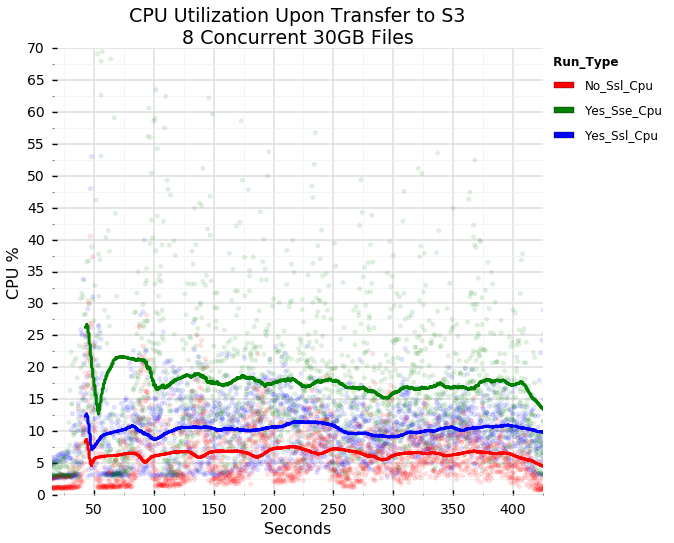

<ggplot: (-9223363304289287792)>

In [51]:
s = ggplot(aes(x='t', y='cpu', color='run_type', fill='run_type'),
           data=async_cpu_df) +\
    stat_smooth(size=3,  alpha=.9, se=False, method="ma") +\
    geom_jitter(alpha=.12) +\
    xlim(15,425) +\
    ylim(0,70) +\
    xlab("Seconds") +\
    ylab("CPU %") +\
    ggtitle("CPU Utilization Upon Transfer to S3\n8 Concurrent 30GB Files") +\
    scale_color_manual(values=["red", "green", "blue"]) +\
    theme_seaborn(context='talk',style="whitegrid")

if create_external_graphs: ggsave("/tmp/network-cpu-1.png", s, dpi=96)
s

Here is a density graph showing the distribution of CPU utilization values across the various run types.

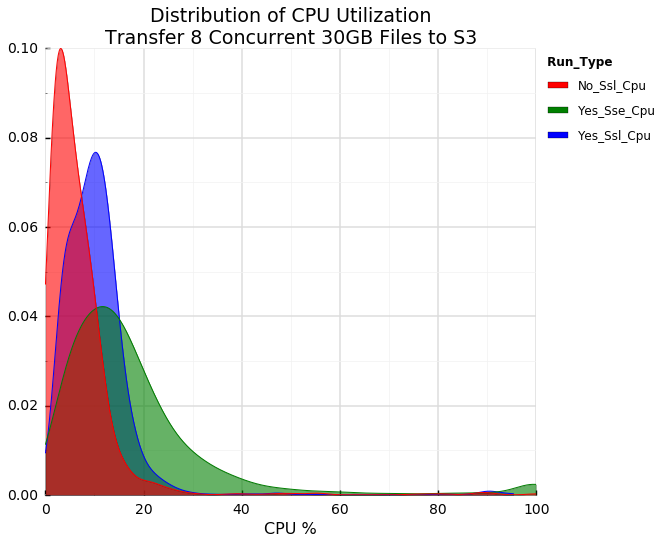

<ggplot: (-9223363304289315240)>

In [52]:
s = ggplot(aes(x='cpu', color='run_type', fill='run_type'), data=async_cpu_df) +\
    geom_density(alpha=.6) +\
    scale_color_manual(values=["red", "green", "blue"]) +\
    xlab("CPU %") +\
    ggtitle("Distribution of CPU Utilization\nTransfer 8 Concurrent 30GB Files to S3") +\
    theme_seaborn(context='talk',style="whitegrid")

if create_external_graphs: ggsave("/tmp/network-cpu-2.png", s, dpi=96)
s

### Single File Upload

A more realistic scenario.

In [53]:
# PROCESS SAR CPU METRICS
SAMPLES = 8
SAMPLE_RANGE = range(SAMPLES)

single_no_ssl_cpus = tuple(cpu_df(os.path.join("reports2", "single_no_ssl_no_sse-cpu.{}.sar.txt".format(i)))
                          for i in SAMPLE_RANGE)
single_yes_ssl_cpus = tuple(cpu_df(os.path.join("reports2", "single_yes_ssl_no_sse-cpu.{}.sar.txt".format(i)))
                           for i in SAMPLE_RANGE)
single_yes_sse_cpus = tuple(cpu_df(os.path.join("reports2", "single_yes_ssl_yes_sse-cpu.{}.sar.txt".format(i)))
                           for i in SAMPLE_RANGE)

for df in single_no_ssl_cpus + single_yes_sse_cpus + single_yes_ssl_cpus:
    df.columns = CPU_COLS

single_no_ssl_cpu = pd.DataFrame({"s{}".format(i): 100-df.cpu for (i,df) in enumerate(single_no_ssl_cpus)})
single_no_ssl_cpu.df_name = "no_ssl_cpu"
single_yes_ssl_cpu = pd.DataFrame({"s{}".format(i): 100-df.cpu for (i,df) in enumerate(single_yes_ssl_cpus)})
single_yes_ssl_cpu.df_name = "yes_ssl_cpu"
single_yes_sse_cpu = pd.DataFrame({"s{}".format(i): 100-df.cpu for (i,df) in enumerate(single_yes_sse_cpus)})
single_yes_sse_cpu.df_name = "yes_sse_cpu"

single_cpu = [single_no_ssl_cpu, single_yes_ssl_cpu, single_yes_sse_cpu]

for i in range(len(single_cpu)):
    df_name = single_cpu[i].df_name
    single_cpu[i]["t"] = single_cpu[i].index
    single_cpu[i] = pd.melt(single_cpu[i], ["t"], var_name="run", value_name=single_cpu[i].df_name)
    single_cpu[i].df_name = df_name

single_cpu_df = pd.melt(reduce(lambda x,y: pd.merge(x, y, on=["t","run"]), single_cpu), 
             id_vars=["t","run"],
             value_name="cpu",
             var_name="run_type",
)

In [54]:
single_cpu_df.head()

,t,run,run_type,cpu
0,0,s0,no_ssl_cpu,0.03
1,1,s0,no_ssl_cpu,26.55
2,2,s0,no_ssl_cpu,0.46
3,3,s0,no_ssl_cpu,0.53
4,4,s0,no_ssl_cpu,0.52


In [55]:
single_cpu_df[["run_type", "cpu"]].groupby(["run_type"]).mean()

,cpu
run_type,
no_ssl_cpu,2.714450
yes_sse_cpu,6.170908
yes_ssl_cpu,2.932665


In [56]:
single_cpu_df[["run_type", "cpu"]].groupby(["run_type"]).std()

,cpu
run_type,
no_ssl_cpu,4.228388
yes_sse_cpu,8.880762
yes_ssl_cpu,4.545221


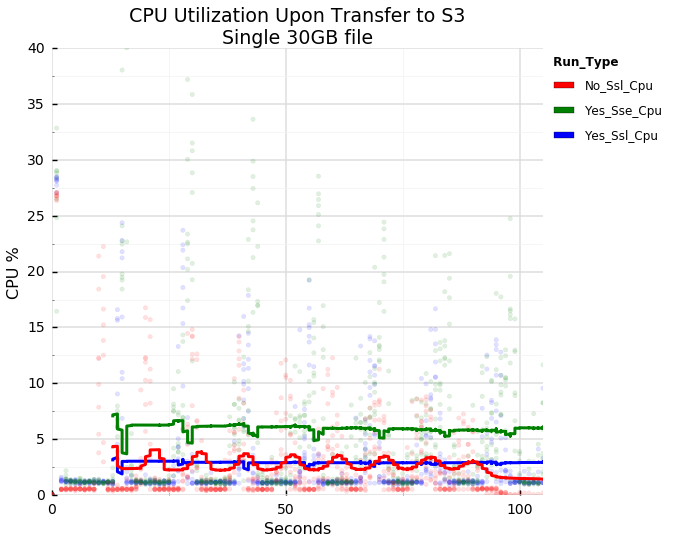

<ggplot: (-9223363304289304425)>

In [57]:
s = ggplot(aes(x='t', y='cpu', color='run_type', fill='run_type'),
           data=single_cpu_df) +\
    stat_smooth(size=3,  alpha=.9, se=False, method="ma", window=105) +\
    geom_jitter(alpha=.12) +\
    xlim(0,105) +\
    ylim(0,40) +\
    xlab("Seconds") +\
    ylab("CPU %") +\
    ggtitle("CPU Utilization Upon Transfer to S3\nSingle 30GB file") +\
    scale_color_manual(values=["red", "green", "blue"]) +\
    theme_seaborn(context='talk', style="whitegrid")

if create_external_graphs: ggsave("/tmp/single-network-cpu-1.png", s, dpi=96)
s

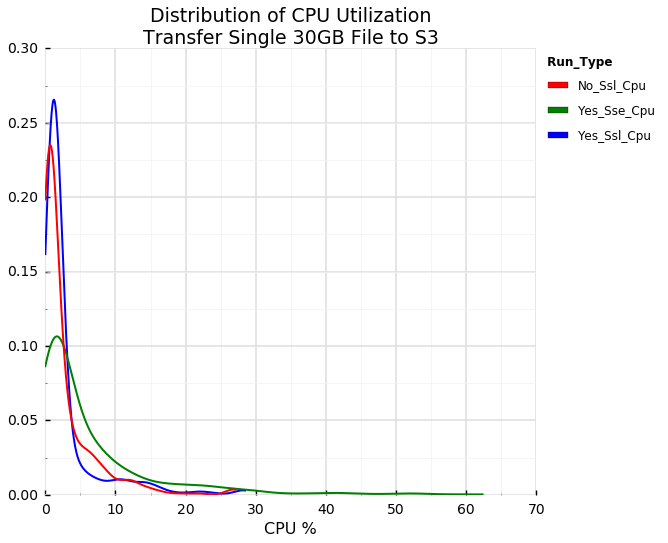

<ggplot: (-9223363304289321514)>

In [58]:
s = ggplot(aes(x='cpu', color='run_type'), data=single_cpu_df) +\
    geom_density(alpha=.6, size=2) +\
    scale_color_manual(values=["red", "green", "blue"]) +\
    xlab("CPU %") +\
    ggtitle("Distribution of CPU Utilization\nTransfer Single 30GB File to S3") +\
    theme_seaborn(context='talk',style="whitegrid")

if create_external_graphs: ggsave("/tmp/single-network-cpu-3.png", s, dpi=96)
s

---

## Disk I/O

Here we are measuring (via [bonnie++](https://www.coker.com.au/bonnie++/)) the relative performace of encrypted disks ([LUKS](https://gitlab.com/cryptsetup/cryptsetup/blob/master/README.md) for [ephemeral](https://docs.aws.amazon.com/AWSEC2/latest/UserGuide/InstanceStorage.html) and [SSE](https://docs.aws.amazon.com/AWSEC2/latest/UserGuide/EBSEncryption.html) for [EBS](https://aws.amazon.com/ebs/)) vs. non encrypted disks for storage of potentially sensitive data and regulatory compliance.

In [59]:
# Process Bonnie Data
samples = []
for dev in ("eph-p", "eph-e", "io-e", "io-p"): 
    with open(os.path.join("reports", "bonnie.{}.txt".format(dev)), "r") as f:
        samples.extend(dev.split("-") + l.strip().split(",") for l in f.readlines()[1:])

bonnie = pd.DataFrame(samples)[[0,1,11, 12, 13,17, 18, 39, 40,]+list(range(42,50))]
bonnie.columns=["dev_type", "enc_flag", "put_block", "put_block_cpu", "rewrite", "get_block",
"get_block_cpu", "put_block_latency","rewrite_latency",
"get_block_latency","seeks_latency","seq_create_latency","seq_stat_latency","seq_del_latency","ran_create_latency","ran_stat_latency","ran_del_latency"]

for l in ("put_block", "get_block", "put_block_cpu", "get_block_cpu"):
    bonnie[l] = bonnie[l].apply(int)
    
for l in ("put_block_latency", "get_block_latency","rewrite_latency","seeks_latency",
          "seq_create_latency","seq_stat_latency","seq_del_latency","ran_create_latency",
          "ran_stat_latency","ran_del_latency"):
    bonnie[l] = bonnie[l].apply(lambda x: int(x[:-2]) if x[-2:] == "us" else int(x[:-2])*1000)

What the data looks like

In [60]:
bonnie.head()

,dev_type,enc_flag,put_block,put_block_cpu,rewrite,get_block,get_block_cpu,put_block_latency,rewrite_latency,get_block_latency,seeks_latency,seq_create_latency,seq_stat_latency,seq_del_latency,ran_create_latency,ran_stat_latency,ran_del_latency
0,eph,p,439625,28,180121,439533,14,22803,458000,20886,4909,136000,274,347000,152000,41,282000
1,eph,p,440489,29,181749,439541,14,26011,378000,15698,389,138000,272,253000,138000,49,287000
2,eph,p,433757,28,178483,439745,14,26556,403000,9400,575,154000,447,215000,137000,47,244000
3,eph,p,406842,27,178898,439132,14,38160,404000,21083,2004,141000,272,231000,162000,49,301000
4,eph,p,407786,27,180905,428006,13,28688,432000,21548,1731,155000,272,300000,150000,48,289000


Averages after 20 test runs

In [61]:
bonnie.groupby(["dev_type","enc_flag"]).mean()

put_block  put_block_cpu  get_block  get_block_cpu  \
dev_type enc_flag                                                       
eph      e         401970.35          30.05  301238.50           10.0   
         p         417092.60          27.20  429359.20           13.6   
io       e         122070.30           7.15  159317.15            5.0   
         p         122065.95           7.70  159151.05            4.7   

                   put_block_latency  rewrite_latency  get_block_latency  \
dev_type enc_flag                                                          
eph      e                2899500.00        3055150.0           16969.05   
         p                  27703.40         408050.0           19099.90   
io       e                  63924.15         831950.0          225400.00   
         p                  70670.00         614350.0          207350.00   

                   seeks_latency  seq_create_latency  seq_stat_latency  \
dev_type enc_flag                                                        
eph      e               1353.95            158950.0            315.30   
         p               2321.35            150950.0            293.70   
io       e               7081.40            163400.0            289.35   
         p              10491.50            132500.0            288.55   

                   seq_del_latency  ran_create_latency  ran_stat_latency  \
dev_type enc_flag                                                          
eph      e                345850.0            152800.0             44.20   
         p                277850.0            145550.0             44.45   
io       e               3376650.0            167700.0             46.15   
         p               3439750.0            143100.0             45.70   

                   ran_del_latency  
dev_type enc_flag                   
eph      e                324500.0  
         p                294150.0  
io       e               2748400.0  
         p               2757200.0

In [62]:
bonnie.groupby(["dev_type","enc_flag"]).std()

put_block  put_block_cpu     get_block  get_block_cpu  \
dev_type enc_flag                                                             
eph      e         14553.244273       1.099043   3438.163915       0.000000   
         p         10966.686850       0.695852  19073.253978       0.753937   
io       e             4.256265       0.366348     80.075803       0.000000   
         p             5.689094       0.470162     69.635498       0.470162   

                   put_block_latency  rewrite_latency  get_block_latency  \
dev_type enc_flag                                                          
eph      e              1.104151e+06    342774.634417        5920.586542   
         p              4.134637e+03     37508.560426        3278.288560   
io       e              9.249139e+03     65234.375020       23656.311053   
         p              1.008364e+04    111665.513217       30728.479847   

                   seeks_latency  seq_create_latency  seq_stat_latency  \
dev_type enc_flag                                                        
eph      e            901.393160        17303.711193         59.673762   
         p           3253.026967        19402.861970         52.991658   
io       e           2196.277794        12398.641691         39.017236   
         p           5351.485387         3620.119219         16.294897   

                   seq_del_latency  ran_create_latency  ran_stat_latency  \
dev_type enc_flag                                                          
eph      e            82379.912600         7984.194914          9.795810   
         p            38505.331141         7694.666642          8.531521   
io       e            64047.905590         7934.601108          5.537195   
         p            66211.682067        17311.085587          7.306090   

                   ran_del_latency  
dev_type enc_flag                   
eph      e            74406.069362  
         p            18865.939791  
io       e           132346.992092  
         p           136850.129319

Dev types
+ eph -> Ephemeral
+ io -> EBS

Color legend for graphs:

<span style="color:red; font-size:24px">■</span> **p** - Plaintext<br>
<span style="color:green; font-size:24px">■</span> **e** - Encrypted at rest (LUKS in the case of eph, SSE in the case of EBS)

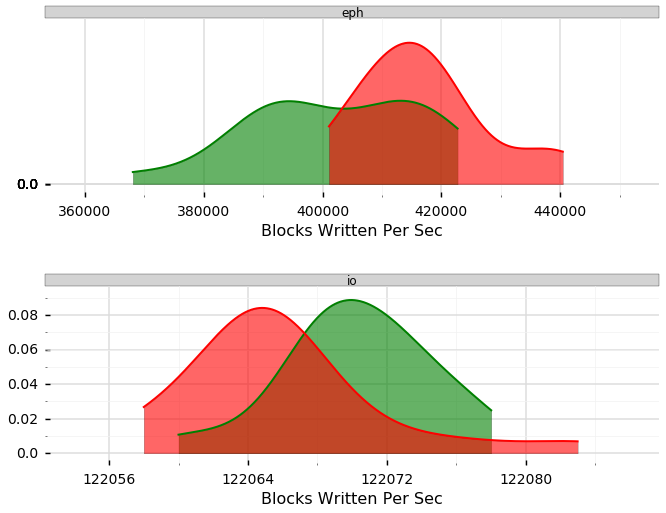

<ggplot: (-9223363304289336572)>

In [63]:
s = ggplot(aes(x="put_block", color="enc_flag", fill="enc_flag"), data=bonnie) +\
    geom_density(alpha=.6, size=2) +\
    facet_wrap("dev_type") +\
    scale_color_manual(values=["green", "red"]) +\
    xlab("Blocks Written Per Sec") +\
    theme_seaborn(context='talk',style="whitegrid")

if create_external_graphs: ggsave("/tmp/disk-io-3.png", s, dpi=96)
s

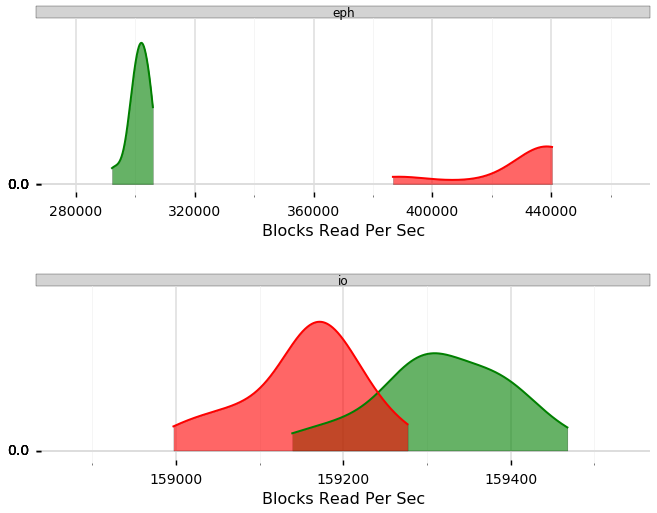

<ggplot: (8732566271650)>

In [64]:
s = ggplot(aes(x="get_block", color="enc_flag", fill="enc_flag"), data=bonnie) +\
    geom_density(alpha=.6, size=2) +\
    facet_wrap("dev_type") +\
    xlab("Blocks Read Per Sec") +\
    scale_color_manual(values=["green", "red"])+\
    theme_seaborn(style="whitegrid",context='talk')

if create_external_graphs: ggsave("/tmp/disk-io-5.png", s, dpi=96)
s